# Imports

In [2]:
try:
  import iminuit
  from iminuit import Minuit
  from iminuit.cost import LeastSquares
except:
  Exception('Error Initialising Iminuit')

In [119]:
import os
from IPython.display import Latex
import sympy as sp
import scipy as sc
import numpy as np
import pandas as pd
# %matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')

# Funcs

In [4]:
#function for removing Nan values from a numpy array
def rNan(arr): return arr[~np.isnan(arr)]

In [5]:
#@title Test ipotesi
def chi_test(fval, ndof, x_limit = 40):
  '''This funciton visualizes the chi2 test for a given chi2 value and degrees of freedom
  Values
  -------

    `fval` : chi2 value

    `ndof` : degrees of freedom
    `x_limit` : chi2 value limit for integral (don't change)
  '''

  x = np.linspace(0,x_limit, 1000)
  y = [sc.stats.chi2.pdf(i,df=ndof) for i in x]

  section = np.arange(fval, x_limit)
  plt.fill_between(section,sc.stats.chi2.pdf(section,df=ndof), alpha=.4)
  plt.title('Test $\chi^2$')
  plt.xlabel(r'$\chi^2$')
  plt.ylabel('$pdf(\chi^2)$')
  plt.legend([r'$\tilde\chi^2$ '+f'= {round(fval/ndof,2)} \n p-value = {round(1 - sc.stats.chi2.cdf(fval,ndof),3)*100}%'])
  plt.plot(x,y)

def t_test(tvalue, df,xlim = 7, alpha = 0.05 ):
  '''This function visualizes the t Student test for a given t value and degrees of freedom
    Values:
    -------

    `tvalue` : t Student test Value
    `df` : dergrees of freedom
    `xlim` : limit for integration (don't change)
  '''

  x = np.linspace(-xlim,xlim,2000)
  y = [ sc.stats.t.pdf(i,df) for i in x]

  section1 = np.linspace(-xlim,-tvalue)
  plt.fill_between(section1,sc.stats.t.pdf(section1,df=df), alpha=.4, color='b')

  section2 = np.linspace(tvalue, xlim)
  plt.fill_between(section2,sc.stats.t.pdf(section2,df=df), alpha=.4, color='b')

  # plt.title('t Test')
  plt.xlabel(r't')
  plt.ylabel('pdf(t)')
  plt.legend([r'$\alpha$'+f' = {round((1-sc.stats.t.cdf(tvalue,df=df))*2, 4)}'])
  plt.plot(x,y)
  return (1-sc.stats.t.cdf(tvalue,df=df))*2

In [6]:
#@title Error Propagation no Covariance

def formula_errori(parametri:str, formula:str, latex_ = False):

    #convert from str to sympy
    parametri = sp.sympify(parametri)
    formula = sp.simplify(formula)
    sigmas = sp.symbols([f'sigma_{var}' for var in parametri])
    i,exp = 0,0

    for val in parametri:

        #squared partial derivatives and sigmas
        exp += sp.diff(formula,val)**2 * sigmas[i]**2
        i+=1

    exp = sp.sqrt(exp)

    if latex_: return '$'+sp.latex(exp)+'$'

    return (exp)

def valuta_errori(formula_errori:str, values:dict, errors:dict, x:dict=None):

  #convert minuit values method to dict
  params = values.keys()

  #sustitute numerical values
  expr = formula_errori.subs(values)

  for val in errors:

    #substitute numerical for sigmas
    expr = expr.subs(f'sigma_{val}', errors[val])

  if x != None: expr = expr.subs(x)

  return expr

In [7]:
# @title media pesata
def media_pesata(x,err) -> tuple['media','sigma']:

  x_ = np.array(x)
  err_ = np.array(err)

  if x_.shape != err_.shape:
    raise Exception('Size mismatch, control arrays!')
    return

  s1,s2 = 0,0
  for i,j in zip(x_,err_):

    s1 += i/j**2
    s2 += 1/j**2

  media = s1/s2
  sigma = np.sqrt(float(1/s2))

  return media,sigma

# Data

In [8]:
data = 'https://docs.google.com/spreadsheets/d/10J8iO8non_Iq_K_8JXAtarPfYMNR1pZCf4Qn8pPsk_4/'
df = pd.read_excel(data+'export?format=xlsx',sheet_name=None)
print(df.keys())

dict_keys(['RC', 'RL', 'RLC_sovra', 'RLC_sotto', 'RLC_crit'])


# other funcs

In [120]:
def find_file(path:str,name:str):
    for fname in os.listdir(path):    # change directory as needed
        if name in fname:
            return fname
    return None

In [124]:
def get_data(path:str):
    '''This function loads the data from the oscilloscope'''

    try:
        name = find_file(path,'CH1')
        if name != None:
            first_channel = pd.read_csv(path+name).iloc[:,3].to_numpy(np.float32) , pd.read_csv(path+name).iloc[:,4].to_numpy(np.float32)
        else:
            first_channel = None
    except:
        first_channel = None
        print('Error loading first channel')

    try:
        name = find_file(path,'CH2')
        if name != None:
            second_channel = pd.read_csv(path+name).iloc[:,3].to_numpy(np.float32) , pd.read_csv(path+name).iloc[:,4].to_numpy(np.float32)
        else:
            second_channel = None
    except:
        second_channel = None
        print('Error loading second channel')
        
    try:
        name = find_file(path,'MTH')
        if name != None:
            third_channel = pd.read_csv(path+name).iloc[:,3].to_numpy(np.float32) , pd.read_csv(path+name).iloc[:,4].to_numpy(np.float32)
        else:
            third_channel = None
    except:
        third_channel = first_channel[0], np.zeros(first_channel[0].shape)
        print('Error loading third channel')
    

    return first_channel, second_channel, third_channel

# RC 
<p1> R = 200 $\Omega$

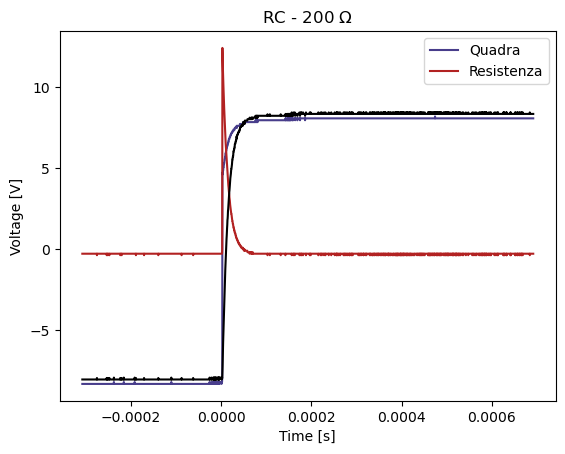

In [129]:
RC_200_s_quadra, RC_200_s_data, RC_200_s_math  = get_data('data/RC_200_salita/')
RC_200_s_math = RC_200_s_data[0], (RC_200_s_quadra[1] - RC_200_s_data[1])

plt.title('RC - 200 $\Omega$')
plt.plot(RC_200_s_quadra[0],RC_200_s_quadra[1],c='darkslateblue')
plt.plot(RC_200_s_data[0],RC_200_s_data[1], c='firebrick')
plt.plot(RC_200_s_math[0],RC_200_s_math[1], c='black')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Quadra','Resistenza'])
plt.show()

In [130]:
def V_RC(t,V_o,R,C,T, offset):
    return V_o*( 1 - 2*(np.exp(-(t+offset)/(R*C)) / (1+np.exp( -T/(R*C) ) ) ) )

In [131]:
def V_RC_2(t,V_o,R,C,T, offset):
    return -V_o*( 1 - 2*(np.exp(- ((t+offset)-(T/2)) /(R*C)) / (1+np.exp( -T/(R*C) ) ) ) )

In [132]:
def exp1(t,V_o,R,C,offset):
    return V_o*np.exp(-t/(R*C)) + offset

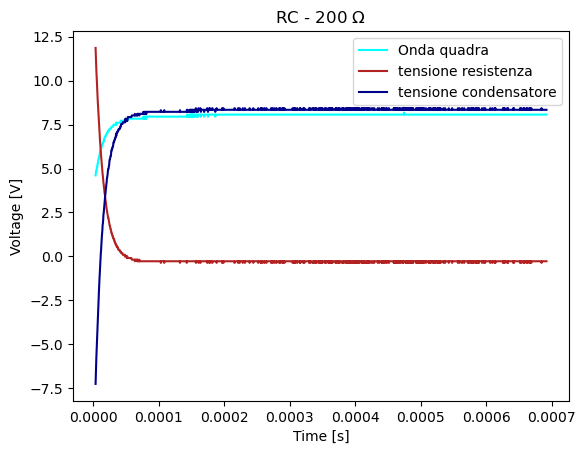

In [133]:
i = 0
v = RC_200_s_data[1][0]
while(v < np.max(RC_200_s_data[1])):
    v = RC_200_s_data[1][i]
    i+=1

plt.title('RC - 200 $\Omega$')
plt.plot(RC_200_s_quadra[0][i:],RC_200_s_quadra[1][i:],c='cyan')
plt.plot(RC_200_s_data[0][i:],RC_200_s_data[1][i:], c='firebrick')
plt.plot(RC_200_s_math[0][i:],RC_200_s_math[1][i:], c='darkblue')

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione condensatore'])
plt.show()

In [134]:
c = LeastSquares(RC_200_s_math[0][i:],RC_200_s_math[1][i:], .01, exp1)
m = Minuit(c, R=250,V_o=8, C=49*1e-9, offset=0)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.105e+04 (χ²/ndof = 41.4) │              Nfcn = 563              │
│ EDM = 9.37e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o    │  -19.558  │   0.006   │            │            │         │         │       │
│ 1 │ R      │  1.549e3  │  0.004e3  │            │            │         │         │       │
│ 2 │ C      │ 8.435e-9  │ 0.020e-9  │            │            │         │         │       │
│ 3 │ offset │  8.33138  │  0.00025  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────────┐
│        │                V_o                  R                  C             offset │
├────────┼─────────────────────────────────────────────────────────────────────────────┤
│    V_o │           3.12e-05           1.180e-3      6.4288518e-15            0.08e-6 │
│      R │           1.180e-3               13.8 -74.3772439367e-12           13.07e-6 │
│      C │      6.4288518e-15 -74.3772439367e-12           4.09e-22        71.1897e-18 │
│ offset │            0.08e-6           13.07e-6        71.1897e-18           6.28e-08 │
└────────┴─────────────────────────────────────────────────────────────────────────────┘

In [135]:
c = LeastSquares(RC_200_s_math[0][i:],RC_200_s_math[1][i:], .0001, V_RC)
m = Minuit(c, R=236.4	,V_o=8.35174, C=58.2e-9,T=0.025, offset=0)
m.fixed['T'] = True
m.limits['C','R'] = (0,np.inf)
m.migrad()
m.hesse()

/tmp/ipykernel_16096/1102844824.py:2: RuntimeWarning: overflow encountered in exp
  return V_o*( 1 - 2*(np.exp(-(t+offset)/(R*C)) / (1+np.exp( -T/(R*C) ) ) ) )
/tmp/ipykernel_16096/1102844824.py:2: RuntimeWarning: overflow encountered in multiply
  return V_o*( 1 - 2*(np.exp(-(t+offset)/(R*C)) / (1+np.exp( -T/(R*C) ) ) ) )


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.693e+09 (χ²/ndof = 2149425.8)│              Nfcn = 119              │
│ EDM = 4.05e+09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o    │ 8.3517399 │ 0.0000025 │            │            │         │         │       │
│ 1 │ R      │  244.306  │   0.006   │            │            │    0    │         │       │
│ 2 │ C      │62.1808e-9 │ 0.0016e-9 │            │            │    0    │         │       │
│ 3 │ T      │ 25.00e-3  │  0.25e-3  │            │            │         │         │  yes  │
│ 4 │ offset │    -0     │  0.05e-9  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│        │               V_o                 R                 C                 T            offset │
├────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│    V_o │          6.38e-12           271e-12       69.6374e-21             0e-12       22.8508e-18 │
│      R │           271e-12          3.85e-05 -9.6902291606e-15                 0    21.9467966e-15 │
│      C │       69.6374e-21 -9.6902291606e-15           2.5e-24                 0           5.6e-24 │
│      T │             0e-12                 0                 0                 0                 0 │
│ offset │       22.8508e-18    21.9467966e-15           5.6e-24                 0          2.77e-21 │
└────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

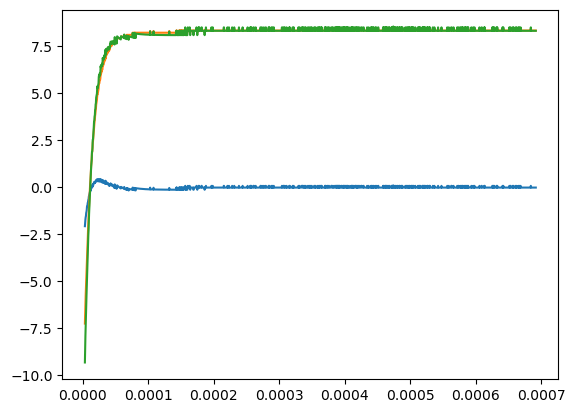

In [136]:
resti = [i-j for i,j in zip(RC_200_s_math[1][i:],V_RC(RC_200_s_math[0][i:],m.values['V_o'],m.values['R'],m.values['C'],m.values['T'],m.values['offset']))]
plt.plot(RC_200_s_math[0][i:],resti)
plt.plot(RC_200_s_math[0][i:],RC_200_s_math[1][i:])
plt.plot(RC_200_s_math[0][i:], RC_200_s_math[1][i:] + resti)

# RC 
<p1> R = 400 $\Omega$

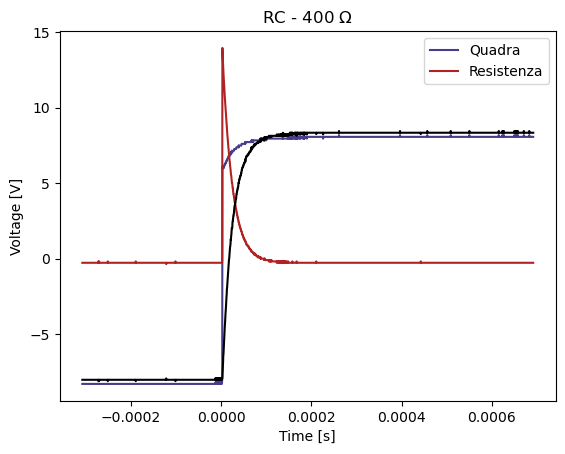

In [137]:
RC_400_s_quadra, RC_400_s_data, RC_400_s_math  = get_data('data/RC_400_salita/')
RC_400_s_math = RC_400_s_data[0], (RC_400_s_quadra[1] - RC_400_s_data[1])

plt.title('RC - 400 $\Omega$')
plt.plot(RC_400_s_quadra[0],RC_400_s_quadra[1],c='darkslateblue')
plt.plot(RC_400_s_data[0],RC_400_s_data[1], c='firebrick')
plt.plot(RC_400_s_math[0],RC_400_s_math[1], c='black')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Quadra','Resistenza'])
plt.show()

# RL

In [138]:
def V_RL(t,V_o,R,L,T):
    if V_o > 0:
        return V_o* 2*(np.exp(-t*R/L) / (1 + np.exp( -T*R/L) ) )
    else:
        return V_o* 2*(np.exp(-(t-(T/2))*R/L) / (1 + np.exp( -T*R/L) ) )

In [139]:
def V_RL_2(t,V_o,tau,c):
    return V_o*(np.exp(-t/tau))+c

In [140]:
RL_quadra = pd.read_csv('data/RL_200ohm/F0002CH1.CSV')
RL_data = pd.read_csv('data/RL_200ohm/F0002CH2.CSV')
RL_ind_v = RL_quadra[RL_quadra.keys()[4]] - RL_data[RL_data.keys()[4]]

plt.scatter(RL_data[RL_data.keys()[3]],RL_data[RL_data.keys()[4]],c='salmon')
plt.scatter(RL_quadra[RL_quadra.keys()[3]],RL_quadra[RL_quadra.keys()[4]], c='purple')
plt.scatter(RL_data[RL_data.keys()[3]],RL_ind_v, c='red')

FileNotFoundError: [Errno 2] No such file or directory: 'data/RL_200ohm/F0002CH1.CSV'

250


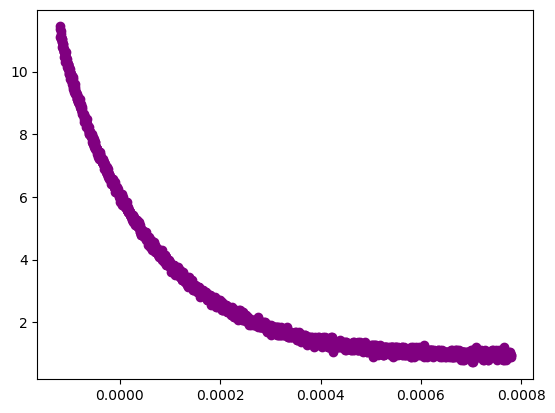

In [ ]:
i=0
v=RL_ind_v[0]

while(v < np.max(RL_ind_v)):
    v=RL_ind_v[i]
    i+=1
plt.scatter((RL_quadra[RL_quadra.keys()[3]])[i:],(RL_ind_v)[i:], c='purple')
print(i)

In [ ]:
1/42

0.023809523809523808

In [ ]:
np.min(RL_ind_v[i:])

0.7199999999999998

In [ ]:
c = LeastSquares(RL_data[RL_data.keys()[3]][i:],RL_ind_v[i:], .1, V_RL_2)
m = Minuit(c, tau = 1e-4,V_o=8, c=0.7)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1365 (χ²/ndof = 0.6)       │              Nfcn = 122              │
│ EDM = 3.01e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o  │   5.178   │   0.007   │            │            │         │         │       │
│ 1 │ tau  │ 177.4e-6  │  0.4e-6   │            │            │         │         │       │
│ 2 │ c    │   0.858   │   0.004   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────┐
│     │         V_o         tau           c │
├─────┼─────────────────────────────────────┤
│ V_o │    4.33e-05  1.74394e-9   -0.022e-3 │
│ tau │  1.74394e-9    1.26e-13 -1.08578e-9 │
│   c │   -0.022e-3 -1.08578e-9    1.66e-05 │
└─────┴─────────────────────────────────────┘

In [ ]:
tau = m.values['tau']
R = 200+39
L = tau*R
print('Induttanza:',L)

Induttanza: 0.04239793657283182


# RLC sottosmorzato

In [ ]:
def V_RLC_st(t,V_o,R,L,C):
    '''tensione in regime sottosmorzato'''
    betha = np.sqrt( (1/(L*C))**2 - (R/L)**2 )
    return V_o*np.exp(-t*R/L)*np.sin(t*betha)

# RLC sovrasmorzato 

In [ ]:
def V_RLC_sv(t,V_o,R,L,C):
    '''tensione in regime sovrasmorzato'''
    betha = np.sqrt( (R/L)**2 - (1/(L*C))**2 )
    return V_o*np.exp(-t*R/L)*[np.exp(t*betha) - np.exp(-t*betha)]

# RLC critico

In [ ]:
def V_RLC_crt(t,V_o,R,L,C):
    '''tensione in regime critico'''
    return V_o*t*np.exp(-t*R/L)